In [2]:
import pandas as pd
import pickle
import random
from rdkit import Chem
import itertools
import torch
import numpy as np
from enhancement_utility import generate_smiles, smiles_to_fingerprint

seed = 12

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
df = pd.read_csv('deoxyfluorination_cleaned.csv', index_col=False)
print(df.head())
pickle_path = 'deoxyfluorination.pkl'

with open(pickle_path, 'rb') as f:
    model = pickle.load(f)

proxy_model = model.predict
THRESHOLD = 0.05

          substrate              base  \
0  OCCCCC1=CC=CC=C1  N12CCCN=C1CCCCC2   
1  OCCCCC1=CC=CC=C1  N12CCCN=C1CCCCC2   
2  OCCCCC1=CC=CC=C1  N12CCCN=C1CCCCC2   
3  OCCCCC1=CC=CC=C1  N12CCCN=C1CCCCC2   
4  OCCCCC1=CC=CC=C1  N12CCCN=C1CCCCC2   

                                  fluoride  yield  
0                ClC1=CC=C(S(=O)(F)=O)C=C1   0.42  
1                    O=S(C1=CC=CC=N1)(F)=O   0.48  
2          O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O   0.47  
3      O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   0.52  
4  FC(C(F)(S(=O)(F)=O)F)(F)C(F)(F)C(F)(F)F   0.52  


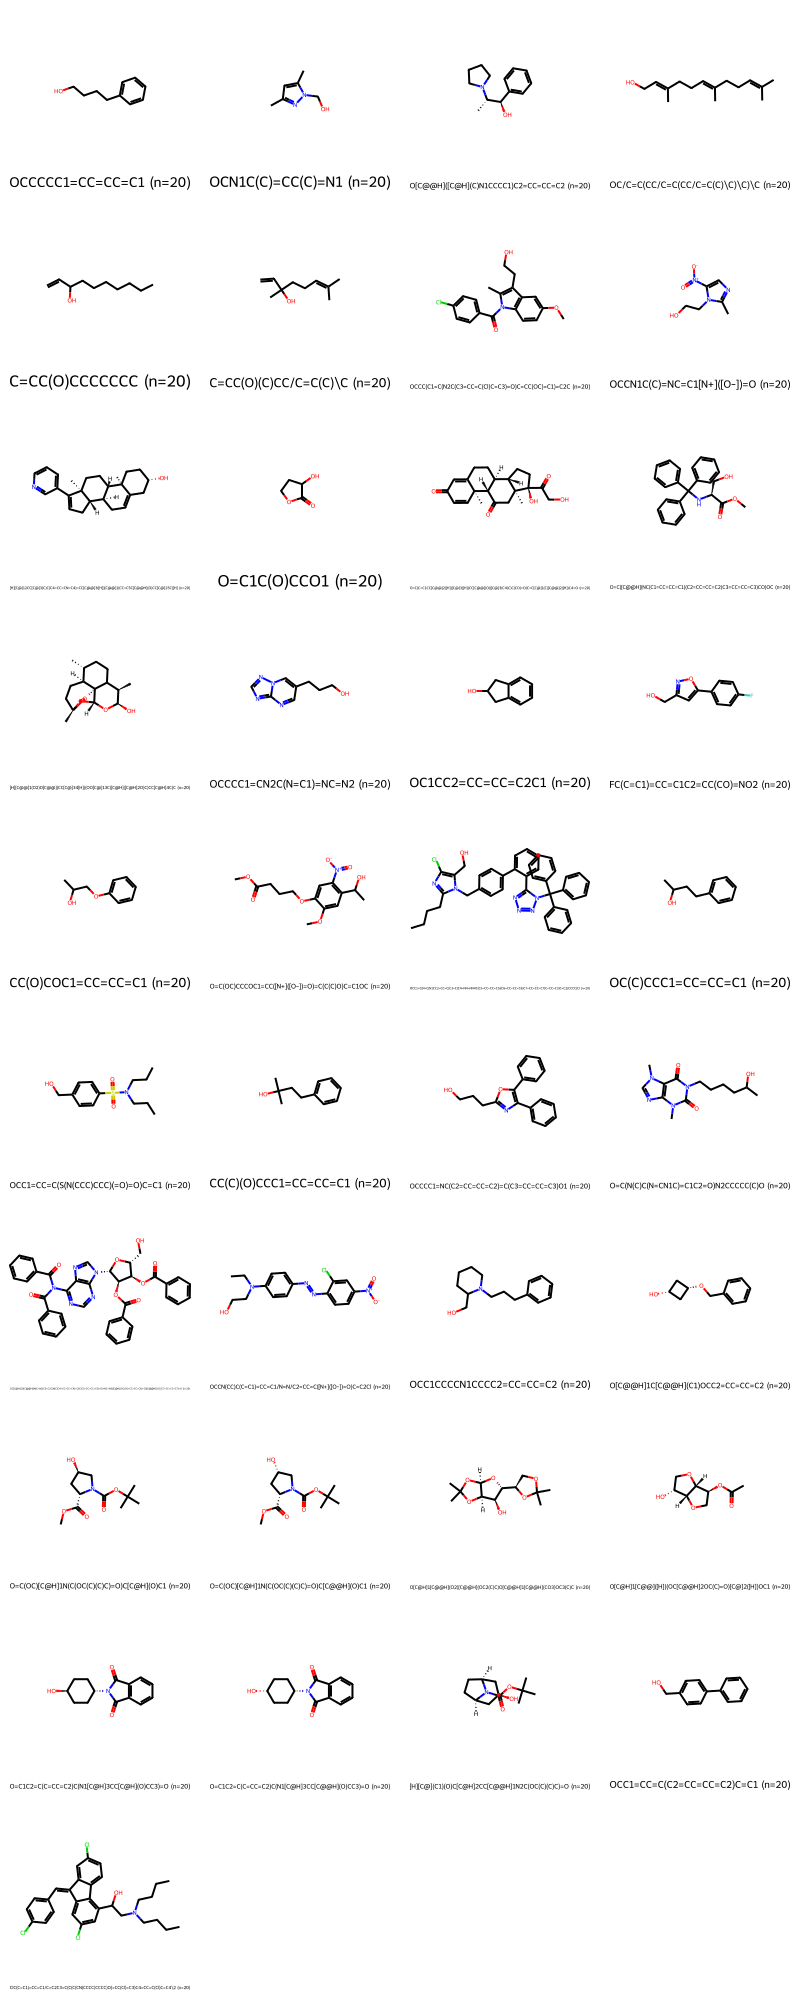

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Assuming df is your DataFrame and the column containing SMILES is called 'Nucleophile'

# Calculate the frequency of each unique SMILES
frequency = df['substrate'].value_counts()

# Create a DataFrame with unique nucleophiles and their counts
unique_nucleophiles = pd.DataFrame({
    'substrate': frequency.index,
    'Count': frequency.values
})

# Convert each unique SMILES to an RDKit Molecule object
unique_nucleophiles['Molecule'] = unique_nucleophiles['substrate'].apply(Chem.MolFromSmiles)

# Prepare the list of molecules and the legends (SMILES + count)
mols = unique_nucleophiles['Molecule'].tolist()
legends = [f"{smi} (n={count})" for smi, count in zip(unique_nucleophiles['substrate'], unique_nucleophiles['Count'])]

# Draw the molecules in a grid with the frequency in the legend
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=legends)

# Display the image within the Jupyter notebook
display(img)

In [6]:
substrates = df['substrate'].tolist()
random.shuffle(substrates)
bases = list(set(df['base'].tolist()))
fluorides = list(set(df['fluoride'].tolist()))

substrates_enhanced = []

In [7]:
for substrate in substrates:
    substrates_enhanced.extend(generate_smiles(substrate))

In [8]:
substrate_pattern = Chem.MolFromSmarts('[OH]')
substrates_filtered = []

for smi in substrates_enhanced:
    mol = Chem.MolFromSmiles(smi)
    if mol.HasSubstructMatch(substrate_pattern):
        substrates_filtered.append(smi)

substrates_filtered = list(set(substrates_filtered))
print(len(substrates_filtered))

4349


In [9]:
combinations = list(itertools.product(bases, fluorides, substrates_filtered))
print(len(combinations), len(substrates_filtered))
df_enhanced = pd.DataFrame(combinations, columns=['base', 'fluoride', 'substrate'])
print(df_enhanced.head(), len(df_enhanced))

86980 4349
                        base                             fluoride  \
0  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   
1  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   
2  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   
3  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   
4  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   

                                           substrate  
0                     COC(=O)C1CC(O)CN1C(=O)OCCC(C)C  
1  CC=CC=C=CC(c1ccccc1)[C+](c1ccccc1)n1nnnc1-c1cc...  
2  O=C(OC1C(C(=O)c2ccccc2)PC(OO)OC1n1cnc2c(N(C(=O...  
3  [C-]#CCCCN(CC(O)c1cc(Cl)cc2c1-c1ccc(Cl)cc1C2=C...  
4                                  C=[C-]C(O)CCCCCCC   86980


In [10]:
fingerprints = []
for index, row in df_enhanced.iterrows():
    base_fp = smiles_to_fingerprint(row['base'])
    fluoride_fp = smiles_to_fingerprint(row['fluoride'])
    substrate_fp = smiles_to_fingerprint(row['substrate'])

    concatenated_fp = torch.cat((base_fp, fluoride_fp, substrate_fp))
    fingerprints.append(concatenated_fp)
    
X = torch.stack(fingerprints)
print(X.shape)

y = proxy_model(X)
print(y.shape)

df_enhanced['yield'] = y

print(df_enhanced.head(), len(df_enhanced))
print(len(df_enhanced['substrate'].unique()), len(df_enhanced['base'].unique()), len(df_enhanced['fluoride'].unique()))

torch.Size([86980, 3072])
(86980,)
                        base                             fluoride  \
0  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   
1  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   
2  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   
3  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   
4  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   

                                           substrate     yield  
0                     COC(=O)C1CC(O)CN1C(=O)OCCC(C)C  0.425975  
1  CC=CC=C=CC(c1ccccc1)[C+](c1ccccc1)n1nnnc1-c1cc...  0.464735  
2  O=C(OC1C(C(=O)c2ccccc2)PC(OO)OC1n1cnc2c(N(C(=O...  0.344019  
3  [C-]#CCCCN(CC(O)c1cc(Cl)cc2c1-c1ccc(Cl)cc1C2=C...  0.757090  
4                                  C=[C-]C(O)CCCCCCC  0.334339   86980
4349 4 5


In [11]:
mean_yield = df_enhanced.groupby('substrate')['yield'].mean()

substrates_below_threshold = mean_yield[mean_yield < THRESHOLD].index

print(substrates_below_threshold)

df_enhanced = df_enhanced[df_enhanced['substrate'].isin(substrates_below_threshold)]

print(df_enhanced.head(), len(df_enhanced))
print(len(df_enhanced['substrate'].unique()), len(df_enhanced['base'].unique()), len(df_enhanced['fluoride'].unique()))

Index(['C=C=[C-]C(C)(O)CCC=C(C)C', 'C=CC(C)(O)CCC=C(C)C', 'CC(C)(O)CCc1ccccc1',
       'CC(C)=CCCC(C)(O)C=C=S', 'CC12CC(O)CC1=CCC1C2CCC2(C)C(c3cccnc3)=CCC12',
       'CC12CC(O)NCC1=CCC1C2CCC2(C)C(c3cccnc3)=CCC12',
       'CC12CC3C(O)CC1=CCC1C2CCC32C(c3cccnc3)=CCC12',
       'CC12CCC(O)CC1=CCC1C2CCC2(C)C(c3cccnc3)=CCC12',
       'CC12CCC(O)CC1=CCC1[C+]2=CCC2(C)C(c3cccnc3)=CCC12',
       'CC12CCC34CCC(O)CC3=CCC(C4)C1CC=C2c1cccnc1',
       'CC12CCC3C(CC=C4CC(O)CCCC43Cl)C1CC=C2c1cccnc1',
       'CC12C[N+]C(O)CC1=CCC1C2CCC2(C)C(c3cccnc3)=CCC12',
       'CC1C(O)CC2=CCC3C4CC=C(c5cccnc5)C4([O-])CCC3C21C',
       '[C+]=CC(C)(O)CCC=C(C)C',
       '[C+]=CC12CC1C(O)CC=CCC1C3CC=C(c4cccnc4)C3(C)CCC12',
       '[C-]C(O)(C=C)CCC=C(C)C', '[C-]CC=CC(C)(O)CCC=C(C)C'],
      dtype='object', name='substrate')
                           base                             fluoride  \
1135  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O   
1219  CN(C)/C(N(C)C)=N/C(C)(C)C  O=S(C1=CC=C([N+]([O-])=

In [12]:
final_df = pd.concat([df, df_enhanced], ignore_index=True)

print(len(final_df), len(final_df['substrate'].unique()), len(final_df['base'].unique()), len(final_df['fluoride'].unique()))

final_df.to_csv('deoxyfluorination_enhanced.csv', index=False)

1080 54 4 5
